In [322]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

train_ros = pd.read_csv('train.csv', index_col=0)
test_ros = pd.read_csv('test.csv', index_col=0)

train_ros['isTrain'] = True
test_ros['isTrain'] = False

data = pd.concat([train_ros, test_ros], sort=False)

In [323]:
import pyrosm
osm = pyrosm.OSM("filtered.osm.pbf")

In [324]:
atm_geometry = [Point(lon, lat) for lon, lat in zip(data['long'], data['lat'])]
atms = gpd.GeoDataFrame(data, geometry=atm_geometry, crs="EPSG:4326")

selected_categories = ['kindergarten', 'school', 'atm', 'bank', 'hospital', 'fuel', 'bus_station']

pois['category'] = pois['amenity'].apply(lambda x: x if x in selected_categories else 'other')

print(pois['category'].value_counts())


category
other           565435
kindergarten     37364
school           37209
atm              23655
bank             20635
hospital         13820
fuel              3342
bus_station       2897
Name: count, dtype: int64


In [325]:
atms = atms.to_crs(epsg=3857)

poi_geometry = [Point(lon, lat) for lon, lat in zip(pois['lon'], pois['lat'])]
pois_gdf = gpd.GeoDataFrame(pois, geometry=poi_geometry, crs="EPSG:4326")
pois_gdf = pois_gdf.to_crs(epsg=3857)


In [326]:
atms['buffer'] = atms.geometry.buffer(150)


In [327]:
category_presence = {}

for category in selected_categories:
    category_pois = pois_gdf[pois_gdf['category'] == category]
    
    pois_within_buffer = gpd.sjoin(category_pois, atms.set_geometry('buffer'), predicate='within')
    
    presence = pois_within_buffer.groupby('index_right').size().apply(lambda x: 1 if x > 0 else 0)
    category_presence[category] = presence

for category, presence in category_presence.items():
    atms[f'{category}_presence'] = presence.reindex(atms.index, fill_value=0)

atms

id  atm_group                                 address  \
0     8526.0       32.0  EMELYANOVA,34          Y-SAKHALINSK      
1     8532.0       32.0  KOMSOMOLSKAYA,259B     Y.SAKHALINSK      
2     8533.0       32.0  KOMMUN. PR., 32        YUZHNO SAKHAL     
3     8684.0       32.0  LENINGRADSKIY PR.,76A  MOSCOW            
4       37.0       32.0  GVARDEYSKAYA PL., 2    NORILSK           
...      ...        ...                                     ...   
2499  7805.0     5478.0  D. 12, PROEZD ZAREVYI     MOSKVA G       
2500  7395.0     5478.0  D. 2B, UL. MIRA           SOCHI G        
2501  3339.0     8083.0  KARMANITSKIY, 9        Moskva            
2502   675.0     1942.0  3A SHARAPOVSKIY WAY       MYTISHCHI      
2503  3135.0     8083.0  24 KM MKAD, VLADENIE 1 Moskva            

                                            address_rus        lat  \
0     улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...  46.940995   
1     Комсомольская улица, 259, Южно-Сахалинск, Саха...  46.937353   
2     Коммунистический проспект, Южно-Сахалинск, Сах...  46.959413   
3     Ленинградский проспект, 76А, Москва, Россия, 1...  55.805827   
4     Гвардейская площадь, 2, Норильск, Красноярский...  69.343541   
...                                                 ...        ...   
2499         Заревый проезд, 12, Москва, Россия, 127282  55.886488   
2500  улица Мира, 4, Адлерский район, Сочи, Краснода...  43.438310   
2501    Карманицкий переулок, 9, Москва, Россия, 119002  55.748275   
2502  Шараповская улица, 1, Мытищи, Московская облас...  55.910992   
2503             МКАД, 24-й километр, 1, Москва, Россия  55.586807   

            long    target  isTrain                          geometry  \
0     142.738319  0.011500     True  POINT (15889556.988 5932448.267)   
1     142.753348  0.029710     True  POINT (15891230.008 5931854.476)   
2     142.741113  0.009540     True  POINT (15889868.014 5935451.755)   
3      37.515146 -0.094035     True    POINT (4176166.95 7519858.012)   
4      88.211228  0.079277     True  POINT (9819628.983 10858343.208)   
...          ...       ...      ...                               ...   
2499   37.656829       NaN    False   POINT (4191939.029 7535851.734)   
2500   39.912211       NaN    False   POINT (4443007.005 5378926.856)   
2501   37.583571       NaN    False   POINT (4183783.986 7508466.664)   
2502   37.748466       NaN    False   POINT (4202140.013 7540717.047)   
2503   37.724966       NaN    False   POINT (4199524.005 7476596.523)   

                                                 buffer  \
0     POLYGON ((15889706.988 5932448.267, 15889706.2...   
1     POLYGON ((15891380.008 5931854.476, 15891379.2...   
2     POLYGON ((15890018.014 5935451.755, 15890017.2...   
3     POLYGON ((4176316.95 7519858.012, 4176316.227 ...   
4     POLYGON ((9819778.983 10858343.208, 9819778.26...   
...                                                 ...   
2499  POLYGON ((4192089.029 7535851.734, 4192088.307...   
2500  POLYGON ((4443157.005 5378926.856, 4443156.283...   
2501  POLYGON ((4183933.986 7508466.664, 4183933.264...   
2502  POLYGON ((4202290.013 7540717.047, 4202289.291...   
2503  POLYGON ((4199674.005 7476596.523, 4199673.283...   

      kindergarten_presence  school_presence  atm_presence  bank_presence  \
0                         0                0             0              0   
1                         0                0             0              1   
2                         0                0             1              1   
3                         0                0             1              1   
4                         0                0             1              1   
...                     ...              ...           ...            ...   
2499                      0                0             1              0   
2500                      0                0             0              1   
2501                      0                0             0              1   
2502    

In [328]:
atms.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 8765 entries, 0 to 2503
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     8765 non-null   float64 
 1   atm_group              8765 non-null   float64 
 2   address                8765 non-null   object  
 3   address_rus            8345 non-null   object  
 4   lat                    8345 non-null   float64 
 5   long                   8345 non-null   float64 
 6   target                 6261 non-null   float64 
 7   isTrain                8765 non-null   bool    
 8   geometry               8765 non-null   geometry
 9   buffer                 8765 non-null   geometry
 10  kindergarten_presence  8765 non-null   int64   
 11  school_presence        8765 non-null   int64   
 12  atm_presence           8765 non-null   int64   
 13  bank_presence          8765 non-null   int64   
 14  hospital_presence      8765 non-null 

In [329]:
pois_within_buffer_all = gpd.sjoin(pois_gdf, atms.set_geometry('buffer'), predicate='within')

total_poi_count = pois_within_buffer_all.groupby('index_right').size()

atms['total_poi_count'] = total_poi_count.reindex(atms.index, fill_value=0)

print(atms[['lat', 'long', 'total_poi_count']].head())


         lat        long  total_poi_count
0  46.940995  142.738319               21
1  46.937353  142.753348               13
2  46.959413  142.741113               23
3  55.805827   37.515146               48
4  69.343541   88.211228                9


In [400]:
atms

id  atm_group                                 address  \
0     8526.0       32.0  EMELYANOVA,34          Y-SAKHALINSK      
1     8532.0       32.0  KOMSOMOLSKAYA,259B     Y.SAKHALINSK      
2     8533.0       32.0  KOMMUN. PR., 32        YUZHNO SAKHAL     
3     8684.0       32.0  LENINGRADSKIY PR.,76A  MOSCOW            
4       37.0       32.0  GVARDEYSKAYA PL., 2    NORILSK           
...      ...        ...                                     ...   
2499  7805.0     5478.0  D. 12, PROEZD ZAREVYI     MOSKVA G       
2500  7395.0     5478.0  D. 2B, UL. MIRA           SOCHI G        
2501  3339.0     8083.0  KARMANITSKIY, 9        Moskva            
2502   675.0     1942.0  3A SHARAPOVSKIY WAY       MYTISHCHI      
2503  3135.0     8083.0  24 KM MKAD, VLADENIE 1 Moskva            

                                            address_rus        lat  \
0     улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...  46.940995   
1     Комсомольская улица, 259, Южно-Сахалинск, Саха...  46.937353   
2     Коммунистический проспект, Южно-Сахалинск, Сах...  46.959413   
3     Ленинградский проспект, 76А, Москва, Россия, 1...  55.805827   
4     Гвардейская площадь, 2, Норильск, Красноярский...  69.343541   
...                                                 ...        ...   
2499         Заревый проезд, 12, Москва, Россия, 127282  55.886488   
2500  улица Мира, 4, Адлерский район, Сочи, Краснода...  43.438310   
2501    Карманицкий переулок, 9, Москва, Россия, 119002  55.748275   
2502  Шараповская улица, 1, Мытищи, Московская облас...  55.910992   
2503             МКАД, 24-й километр, 1, Москва, Россия  55.586807   

            long    target  isTrain                          geometry  \
0     142.738319  0.011500     True  POINT (15889556.988 5932448.267)   
1     142.753348  0.029710     True  POINT (15891230.008 5931854.476)   
2     142.741113  0.009540     True  POINT (15889868.014 5935451.755)   
3      37.515146 -0.094035     True    POINT (4176166.95 7519858.012)   
4      88.211228  0.079277     True  POINT (9819628.983 10858343.208)   
...          ...       ...      ...                               ...   
2499   37.656829       NaN    False   POINT (4191939.029 7535851.734)   
2500   39.912211       NaN    False   POINT (4443007.005 5378926.856)   
2501   37.583571       NaN    False   POINT (4183783.986 7508466.664)   
2502   37.748466       NaN    False   POINT (4202140.013 7540717.047)   
2503   37.724966       NaN    False   POINT (4199524.005 7476596.523)   

                                                 buffer  \
0     POLYGON ((15889706.988 5932448.267, 15889706.2...   
1     POLYGON ((15891380.008 5931854.476, 15891379.2...   
2     POLYGON ((15890018.014 5935451.755, 15890017.2...   
3     POLYGON ((4176316.95 7519858.012, 4176316.227 ...   
4     POLYGON ((9819778.983 10858343.208, 9819778.26...   
...                                                 ...   
2499  POLYGON ((4192089.029 7535851.734, 4192088.307...   
2500  POLYGON ((4443157.005 5378926.856, 4443156.283...   
2501  POLYGON ((4183933.986 7508466.664, 4183933.264...   
2502  POLYGON ((4202290.013 7540717.047, 4202289.291...   
2503  POLYGON ((4199674.005 7476596.523, 4199673.283...   

      kindergarten_presence  school_presence  atm_presence  bank_presence  \
0                         0                0             0              0   
1                         0                0             0              1   
2                         0                0             1              1   
3                         0                0             1              1   
4                         0                0             1              1   
...                     ...              ...           ...            ...   
2499                      0                0             1              0   
2500                      0                0             0              1   
2501                      0                0             0              1   
2502    

In [331]:
import pyrosm
import pandas as pd
from scipy.spatial import KDTree

osm = pyrosm.OSM("filtered.osm.pbf")

atm_osm = osm.get_pois({"atm": True})

atm_osm_df = pd.DataFrame(atm_osm).dropna(subset=['lat', 'lon'])

atms_clean = atms.dropna(subset=['lat', 'long'])  # Убираем строки с NaN
atm_coords = atms_clean[['lat', 'long']].to_numpy()  # Координаты банкоматов в массив
osm_coords = atm_osm_df[['lat', 'lon']].to_numpy()  # Координаты OSM банкоматов

osm_tree = KDTree(osm_coords)

distances, indices = osm_tree.query(atm_coords)

atms_clean['nearest_atm_index'] = indices
atms_clean['distance_to_nearest_atm'] = distances

print(atms_clean[['id', 'nearest_atm_index', 'distance_to_nearest_atm']])


          id  nearest_atm_index  distance_to_nearest_atm
0     8526.0               4192                 0.015638
1     8532.0               4192                 0.024618
2     8533.0                518                 0.000421
3     8684.0               1129                 0.000260
4       37.0                869                 0.010095
...      ...                ...                      ...
2499  7805.0                512                 0.015481
2500  7395.0               4249                 0.011261
2501  3339.0                607                 0.000479
2502   675.0               4864                 0.007051
2503  3135.0               2153                 0.025201

[8345 rows x 3 columns]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [332]:
from geopy.distance import geodesic

def calculate_geodesic_distance(row):
    atm_coord = (row['lat'], row['long'])
    nearest_atm_coord = osm_coords[row['nearest_atm_index']]
    return geodesic(atm_coord, nearest_atm_coord).meters

atms_clean['distance_to_nearest_atm_meters'] = atms_clean.apply(calculate_geodesic_distance, axis=1)

print(atms_clean[['id', 'distance_to_nearest_atm_meters']])

          id  distance_to_nearest_atm_meters
0     8526.0                     1738.351535
1     8532.0                     2439.586228
2     8533.0                       40.796501
3     8684.0                       23.112886
4       37.0                      558.363811
...      ...                             ...
2499  7805.0                     1532.592900
2500  7395.0                     1139.736700
2501  3339.0                       31.506286
2502   675.0                      764.139241
2503  3135.0                     2763.123806

[8345 rows x 2 columns]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [333]:
columns_to_drop = ['nearest_atm_index', 'distance_to_nearest_atm', 'buffer','geometry','id']
atms_clean = atms_clean.drop(columns=columns_to_drop)

In [334]:
#atms_clean["city"] = atms_clean["address_rus"].str.extract(r"[^,]*,[^,]*,\s*([^,]+),")

In [335]:
atms_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8345 entries, 0 to 2503
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   atm_group                       8345 non-null   float64
 1   address                         8345 non-null   object 
 2   address_rus                     8345 non-null   object 
 3   lat                             8345 non-null   float64
 4   long                            8345 non-null   float64
 5   target                          5957 non-null   float64
 6   isTrain                         8345 non-null   bool   
 7   kindergarten_presence           8345 non-null   int64  
 8   school_presence                 8345 non-null   int64  
 9   atm_presence                    8345 non-null   int64  
 10  bank_presence                   8345 non-null   int64  
 11  hospital_presence               8345 non-null   int64  
 12  fuel_presence                   8345 no

In [336]:
atms_clean.describe(include='all')


atm_group                                 address  \
count   8345.000000                                    8345   
unique          NaN                                    7126   
top             NaN  HOROSHEVSKOE SH,V38       MOSKVA         
freq            NaN                                       7   
mean    4405.440024                                     NaN   
std     2443.152067                                     NaN   
min       32.000000                                     NaN   
25%     1942.000000                                     NaN   
50%     5478.000000                                     NaN   
75%     5478.000000                                     NaN   
max     8083.000000                                     NaN   

                                              address_rus          lat  \
count                                                8345  8345.000000   
unique                                               6147          NaN   
top     квартал В-13, городской округ Волгодонск, Рост...          NaN   
freq                                                   10          NaN   
mean                                                  NaN    54.138304   
std                                                   NaN     4.329293   
min                                                   NaN    42.057080   
25%                                                   NaN    52.243997   
50%                                                   NaN    55.060936   
75%                                                   NaN    56.116673   
max                                                   NaN    69.495093   

               long       target isTrain  kindergarten_presence  \
count   8345.000000  5957.000000    8345            8345.000000   
unique          NaN          NaN       2                    NaN   
top             NaN          NaN    True                    NaN   
freq            NaN          NaN    5957                    NaN   
mean      63.500873     0.000735     NaN               0.009467   
std       32.787366     0.086220     NaN               0.096841   
min       19.941530    -0.145001     NaN               0.000000   
25%       37.851107    -0.061486     NaN               0.000000   
50%       49.071694    -0.015589     NaN               0.000000   
75%       84.950218     0.040243     NaN               0.000000   
max      173.706490     0.218608     NaN               1.000000   

        school_presence  atm_presence  bank_presence  hospital_presence  \
count       8345.000000   8345.000000    8345.000000        8345.000000   
unique              NaN           NaN            NaN                NaN   
top                 NaN           NaN            NaN                NaN   
freq                NaN           NaN            NaN                NaN   
mean           0.011025      0.471420       0.448053           0.011863   
std            0.104424      0.499212       0.497324           0.108278   
min            0.000000      0.000000       0.000000           0.000000   
25%            0.000000      0.000000       0.000000           0.000000   
50%            0.000000      0.000000       0.000000           0.000000   
75%            0.000000      1.000000       1.000000           0.000000   
max            1.000000      1.000000       1.000000           1.000000   

        fuel_presence  bus_station_presence  total_poi_count  \
count     8345.000000           8345.000000      8345.000000   
unique            NaN                   NaN              NaN   
top               NaN                   NaN              NaN   
freq              NaN                   NaN              NaN   
mean         0.001797              0.007070        11.009107   
std          0.042361              0.083791        12.750789   
min          0.000000              0.000000         0.000000   
25%          0.000000              0.000000         3.000000   
50%          0.000000              0.000000         7.000000   
75%          0.000

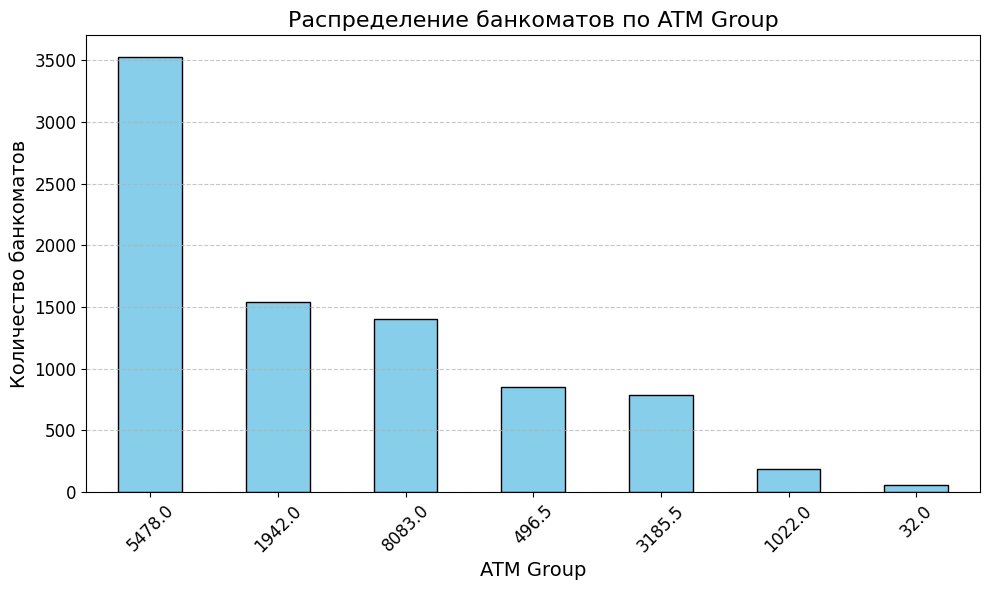

In [337]:
atm_group_counts = atms_clean['atm_group'].value_counts()

plt.figure(figsize=(10, 6))
atm_group_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Распределение банкоматов по ATM Group', fontsize=16)
plt.xlabel('ATM Group', fontsize=14)
plt.ylabel('Количество банкоматов', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


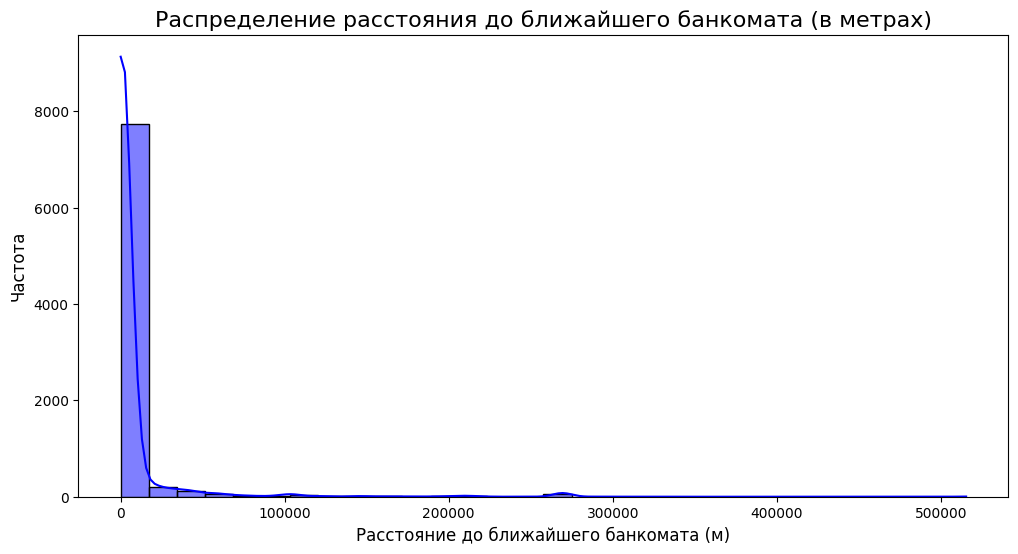

In [338]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(atms_clean['distance_to_nearest_atm_meters'], kde=True, bins=30, color='blue')
plt.title('Распределение расстояния до ближайшего банкомата (в метрах)', fontsize=16)
plt.xlabel('Расстояние до ближайшего банкомата (м)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.show()

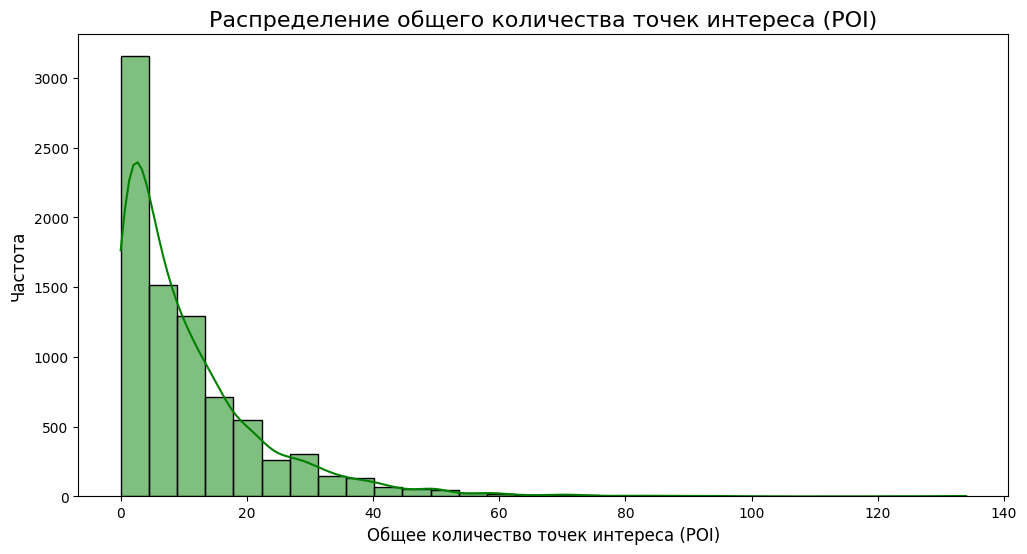

In [339]:
plt.figure(figsize=(12, 6))
sns.histplot(atms_clean['total_poi_count'], kde=True, bins=30, color='green')
plt.title('Распределение общего количества точек интереса (POI)', fontsize=16)
plt.xlabel('Общее количество точек интереса (POI)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.show()

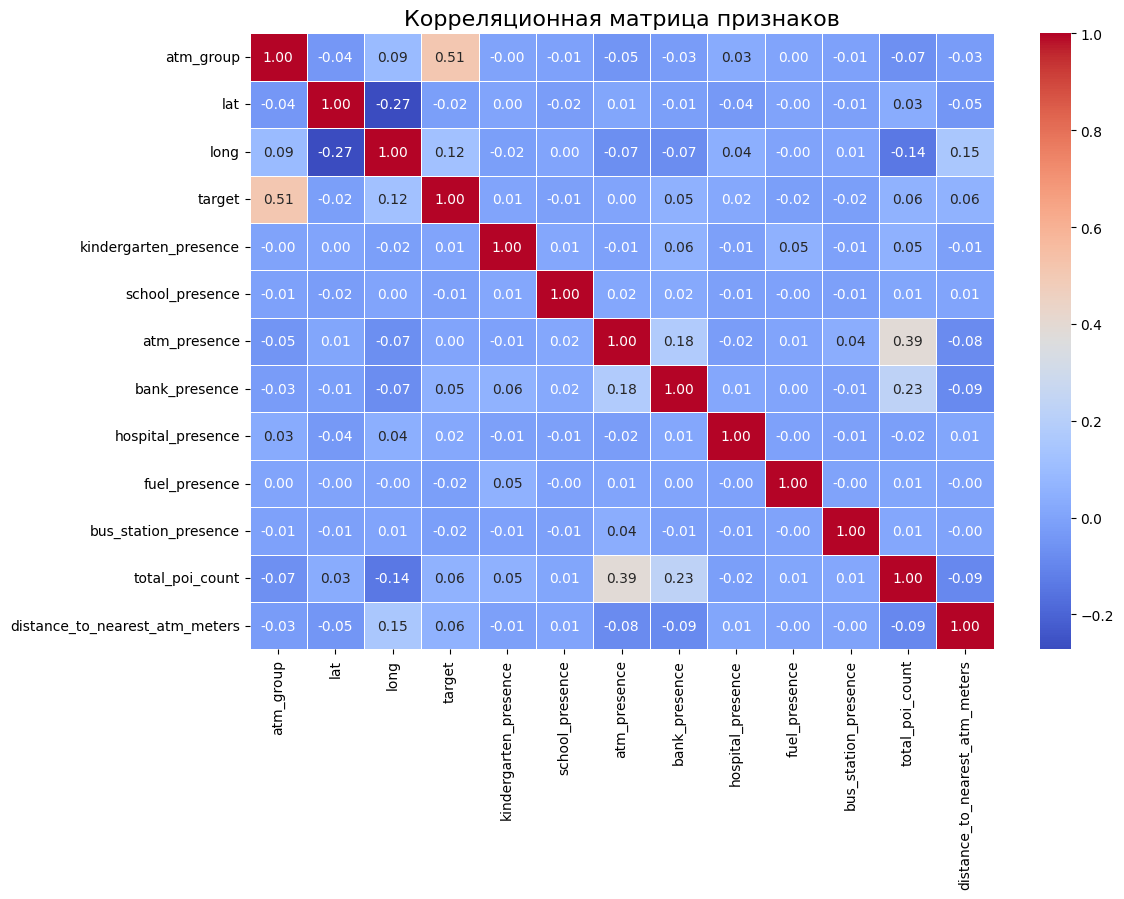

In [340]:
numerical_columns = atms_clean.select_dtypes(include=[np.number])

correlation_matrix = numerical_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Корреляционная матрица признаков", fontsize=16)
plt.show()


In [341]:
target_correlation = correlation_matrix['target'].sort_values(ascending=False)
print("Корреляции с целевой переменной (target):\n", target_correlation)

Корреляции с целевой переменной (target):
 target                            1.000000
atm_group                         0.511837
long                              0.122668
total_poi_count                   0.058812
distance_to_nearest_atm_meters    0.058428
bank_presence                     0.051208
hospital_presence                 0.020317
kindergarten_presence             0.005863
atm_presence                      0.001513
school_presence                  -0.009889
fuel_presence                    -0.016231
lat                              -0.016893
bus_station_presence             -0.017360
Name: target, dtype: float64




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



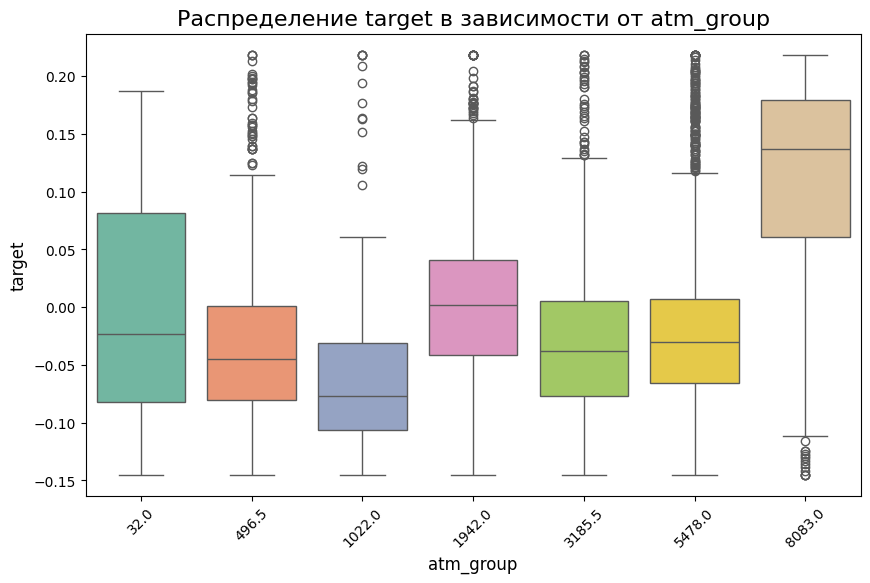



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



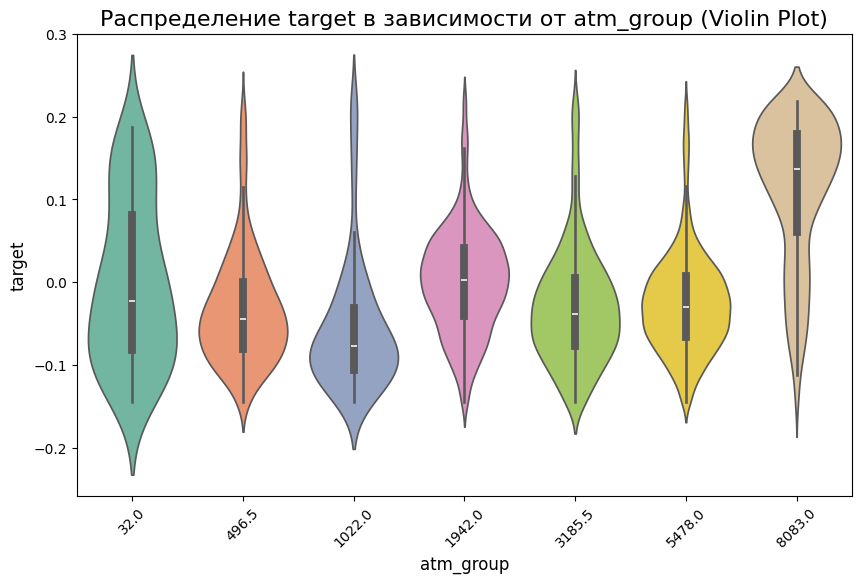

In [342]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='atm_group', y='target', data=atms_clean, palette='Set2')
plt.title('Распределение target в зависимости от atm_group', fontsize=16)
plt.xlabel('atm_group', fontsize=12)
plt.ylabel('target', fontsize=12)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='atm_group', y='target', data=atms_clean, palette='Set2')
plt.title('Распределение target в зависимости от atm_group (Violin Plot)', fontsize=16)
plt.xlabel('atm_group', fontsize=12)
plt.ylabel('target', fontsize=12)
plt.xticks(rotation=45)
plt.show()


## Бейзлайн

In [343]:
atms_clean

atm_group                                 address  \
0          32.0  EMELYANOVA,34          Y-SAKHALINSK      
1          32.0  KOMSOMOLSKAYA,259B     Y.SAKHALINSK      
2          32.0  KOMMUN. PR., 32        YUZHNO SAKHAL     
3          32.0  LENINGRADSKIY PR.,76A  MOSCOW            
4          32.0  GVARDEYSKAYA PL., 2    NORILSK           
...         ...                                     ...   
2499     5478.0  D. 12, PROEZD ZAREVYI     MOSKVA G       
2500     5478.0  D. 2B, UL. MIRA           SOCHI G        
2501     8083.0  KARMANITSKIY, 9        Moskva            
2502     1942.0  3A SHARAPOVSKIY WAY       MYTISHCHI      
2503     8083.0  24 KM MKAD, VLADENIE 1 Moskva            

                                            address_rus        lat  \
0     улица А.О. Емельянова, 34, Южно-Сахалинск, Сах...  46.940995   
1     Комсомольская улица, 259, Южно-Сахалинск, Саха...  46.937353   
2     Коммунистический проспект, Южно-Сахалинск, Сах...  46.959413   
3     Ленинградский проспект, 76А, Москва, Россия, 1...  55.805827   
4     Гвардейская площадь, 2, Норильск, Красноярский...  69.343541   
...                                                 ...        ...   
2499         Заревый проезд, 12, Москва, Россия, 127282  55.886488   
2500  улица Мира, 4, Адлерский район, Сочи, Краснода...  43.438310   
2501    Карманицкий переулок, 9, Москва, Россия, 119002  55.748275   
2502  Шараповская улица, 1, Мытищи, Московская облас...  55.910992   
2503             МКАД, 24-й километр, 1, Москва, Россия  55.586807   

            long    target  isTrain  kindergarten_presence  school_presence  \
0     142.738319  0.011500     True                      0                0   
1     142.753348  0.029710     True                      0                0   
2     142.741113  0.009540     True                      0                0   
3      37.515146 -0.094035     True                      0                0   
4      88.211228  0.079277     True                      0                0   
...          ...       ...      ...                    ...              ...   
2499   37.656829       NaN    False                      0                0   
2500   39.912211       NaN    False                      0                0   
2501   37.583571       NaN    False                      0                0   
2502   37.748466       NaN    False                      0                0   
2503   37.724966       NaN    False                      0                0   

      atm_presence  bank_presence  hospital_presence  fuel_presence  \
0                0              0                  0              0   
1                0              1                  0              0   
2                1              1                  0              0   
3                1              1                  0              0   
4                1              1                  0              0   
...            ...            ...                ...            ...   
2499             1              0                  0              0   
2500             0              1                  0              0   
2501             0              1                  0              0   
2502             0              1                  0              0   
2503             0              0                  0              0   

      bus_station_presence  total_poi_count  distance_to_nearest_atm_meters  
0                        0               21                     1738.351535  
1                        0               13                     2439.586228  
2                        0               23                       40.796501  
3                        0               48                       23.112886  
4                        0                9                      558.363811  
...                    ...              ...                             ...  
2499                     0               15                     1532.592900  
2500                     0    

In [344]:
atms_clean = atms_clean[atms_clean['isTrain'] == True]

Y = atms_clean['target']
X = atms_clean.drop(columns=['target', 'isTrain','address','address_rus'])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [345]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='most_frequent')
cols = X_train.columns

imp.fit(X_train)
X_train[cols] = imp.transform(X_train)
X_test[cols] = imp.transform(X_test)

import pickle

with open("Imputer.pickle", "wb") as f:
    pickle.dump(imp, f)

In [346]:
from category_encoders.target_encoder import TargetEncoder

def target_mean_encoder(X_train, X_test, cols):
    tgt_enc = TargetEncoder(cols=cols)
    Xtrain_new = tgt_enc.fit_transform(X_train,y_train)
    Xtest_new = tgt_enc.transform(X_test)
    return Xtrain_new, Xtest_new, tgt_enc

In [347]:
X_train_mean, X_test_mean, target_encoder = target_mean_encoder(X_train, X_test, ['atm_group'])

In [348]:
cols = ['atm_group']
X_train_enc, X_test_enc, encoder = one_hot_encode_drop_first(X_train, X_test, cols)

In [349]:
X_train_mean.columns

Index(['atm_group', 'lat', 'long', 'kindergarten_presence', 'school_presence',
       'atm_presence', 'bank_presence', 'hospital_presence', 'fuel_presence',
       'bus_station_presence', 'total_poi_count',
       'distance_to_nearest_atm_meters'],
      dtype='object')

In [350]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_encode_drop_first(X_train, X_test, cols):
      drop_enc = OneHotEncoder(drop='first', handle_unknown='ignore').fit(X_train[cols])

      X_train_enc = pd.DataFrame(drop_enc.transform(X_train[cols]).toarray(),
                                columns=drop_enc.get_feature_names_out(cols),
                                dtype=int)
      X_test_enc = pd.DataFrame(drop_enc.transform(X_test[cols]).toarray(),
                                columns=drop_enc.get_feature_names_out(cols),
                                dtype=int)

      X_train_enc = X_train_enc.reset_index(drop=True)
      X_test_enc = X_test_enc.reset_index(drop=True)
      X_train = X_train.reset_index(drop=True)
      X_test = X_test.reset_index(drop=True)

      X_train_enc = pd.concat([X_train.drop(columns=cols), X_train_enc], axis=1)
      X_test_enc = pd.concat([X_test.drop(columns=cols), X_test_enc], axis=1)

      return X_train_enc, X_test_enc, drop_enc

In [351]:
from sklearn.metrics import r2_score, mean_squared_error as MSE

def regression(model, X_train, X_test, y_train, y_test, features):
    model.fit(X_train, y_train)


    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    mse_train = MSE(y_train, pred_train)
    mse_test = MSE(y_test, pred_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))


    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)



    print(f'MSE для трейна равно {mse_train:.4f}')
    print(f'MSE для теста равно {mse_test:.4f}')

    print(f'RMSE для трейна равно {rmse_train:.4f}')
    print(f'RMSE для теста равно {rmse_test:.4f}')

    print(f'r2 для трейна равно {r2_train:.10f}')
    print(f'r2 для теста равно {r2_test:.10f}')

    weights = abs(model.coef_)

    return mse_train, mse_test, r2_train, r2_test, weights

In [352]:
a,b,c,d, weights = regression(LinearRegression(),X_train_mean, X_test_mean, y_train, y_test, X_train_mean.columns)

MSE для трейна равно 0.0024
MSE для теста равно 0.0023
RMSE для трейна равно 0.0490
RMSE для теста равно 0.0482
r2 для трейна равно 0.6772363814
r2 для теста равно 0.6870236533


### Масштабирование

In [353]:
def scale_data(X_train, X_test):
    X_train_sc = X_train.copy()
    X_test_sc = X_test.copy()
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)
    X_train_sc = pd.DataFrame(X_train_sc, columns=X_train.columns)
    X_test_sc = pd.DataFrame(X_test_sc, columns=X_test.columns)
    return  X_train_sc, X_test_sc, scaler

In [354]:
X_train_sc, X_test_sc, scaler = scale_data(X_train_mean, X_test_mean)

In [355]:
a,b,c,d, weights = regression(LinearRegression(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0024
MSE для теста равно 0.0023
RMSE для трейна равно 0.0490
RMSE для теста равно 0.0482
r2 для трейна равно 0.6772363814
r2 для теста равно 0.6870236533


In [356]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def grid_decision_tree(param_grid, cv, X_train, y_train, X_test, y_test):

  # Create an instance of DecisionTreeRegressor
  dt = DecisionTreeRegressor()

  # Create the GridSearchCV object
  grid_search = GridSearchCV(dt, param_grid, cv=cv)

  # Perform grid search to find the optimal hyperparameters
  grid_search.fit(X_train, y_train)

  # Print the optimal hyperparameters
  print("Optimal hyperparameters:", grid_search.best_params_)

  # Get the best decision tree model
  best_tree = grid_search.best_estimator_
  pred_train = best_tree.predict(X_train)
  pred_test = best_tree.predict(X_test)


  # Вычисляем значения метрик MSE и R2 для тренировочного и тестового набора данных
  mse_train = MSE(y_train, pred_train)
  mse_test = MSE(y_test, pred_test)
  # Вычисляем значения метрик RMSE (корень из среднеквадратичной ошибки) и R2 для тренировочного и тестового набора данных
  rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
  rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)


  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')


  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  return mse_train, mse_test, r2_train, r2_test, best_tree

In [357]:
param_grid = {'max_depth': range(2, 16),
              'max_features': range(5, 16)}

cv = 5
a,b,c,d,model = grid_decision_tree(param_grid, cv, X_train_sc, y_train, X_test_sc, y_test)

Optimal hyperparameters: {'max_depth': 4, 'max_features': 12}
MSE для трейна равно 0.0023
MSE для теста равно 0.0023
RMSE для трейна равно 0.0479
RMSE для теста равно 0.0484
r2 для трейна равно 0.6909189368
r2 для теста равно 0.6843685469


In [358]:
def weights_plot(coefs, columns, count, name_model):
  indices = np.argsort(np.abs(coefs))[::-1][:count][::-1]  # Индексы первых 10 наиболее важных признаков

  plt.figure(figsize=(7, 7))
  plt.barh(range(10), np.abs(coefs[indices]))
  plt.yticks(range(10), columns[indices])
  plt.xlabel("Важность")
  plt.ylabel("Признаки")
  plt.title(f"Первые {count} признаков ( по важности, {name_model})")
  plt.show()

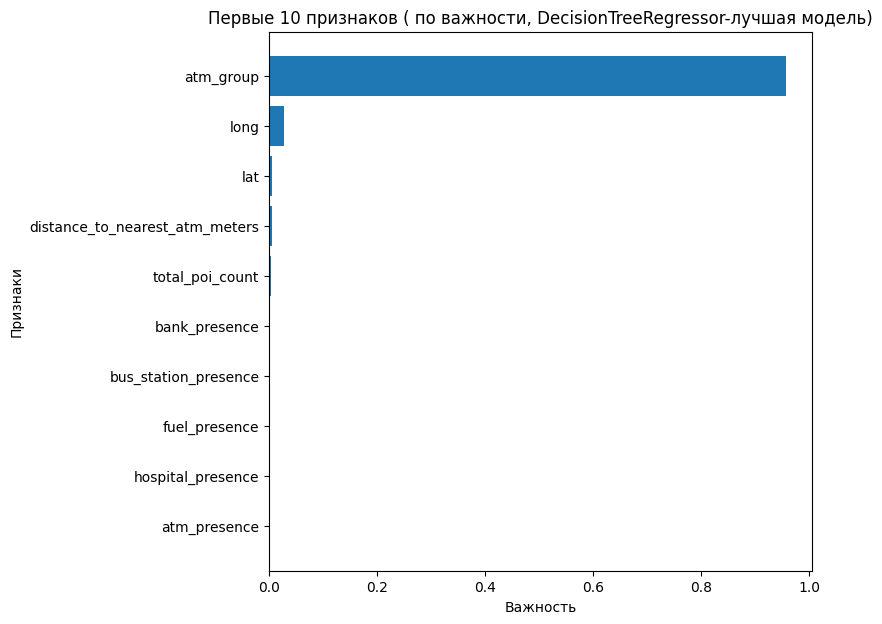

In [359]:
weights_plot(model.feature_importances_, X_train_sc.columns, 10, "DecisionTreeRegressor-лучшая модель")


In [360]:
import shap

def shap_plot(model, X_train_sample, count):
  explainer = shap.Explainer(model, X_train_sample)
  shap_values = explainer(X_train_sample)
  shap.summary_plot(shap_values, X_train_sample, max_display = count)

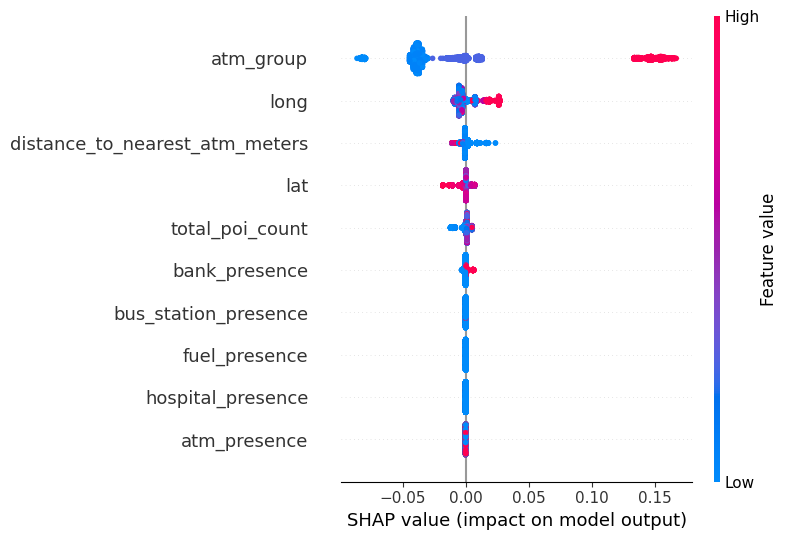

In [361]:
shap_plot(model, X_train_sc, 10)

In [363]:
from sklearn.linear_model import Lasso
a,b,c,d, weights = regression(Lasso(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0074
MSE для теста равно 0.0074
RMSE для трейна равно 0.0862
RMSE для теста равно 0.0862
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0000510637


In [365]:
def grid_search(model,params,cv,scoring,X_train,X_test, y_train, y_test):

  gs = GridSearchCV(model, params, cv=cv, scoring=scoring)

  gs.fit(X_train, y_train)

  print(gs.best_params_)

  pred_train = gs.best_estimator_.predict(X_train)
  pred_test = gs.best_estimator_.predict(X_test)


  # Вычисляем значения метрик MSE и R2 для тренировочного и тестового набора данных
  mse_train = MSE(y_train, pred_train)
  mse_test = MSE(y_test, pred_test)
  # Вычисляем значения метрик RMSE (корень из среднеквадратичной ошибки) и R2 для тренировочного и тестового набора данных
  rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
  rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)


  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')


  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  weights = abs(gs.best_estimator_.coef_)

  return mse_train, mse_test, r2_train, r2_test, weights, gs.best_estimator_


In [366]:
params = {'alpha' : np.linspace(0.0001, 1, 100)}
cv = 5
scoring = 'r2'
a,b,c,d,weights, best_lasso = grid_search(Lasso(),params,cv,scoring,X_train_sc,X_test_sc, y_train, y_test)

{'alpha': 0.0001}
MSE для трейна равно 0.0024
MSE для теста равно 0.0023
RMSE для трейна равно 0.0490
RMSE для теста равно 0.0482
r2 для трейна равно 0.6772203177
r2 для теста равно 0.6872263152


In [369]:
from sklearn.linear_model import Ridge
a,b,c,d, weights = regression(Ridge(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0024
MSE для теста равно 0.0023
RMSE для трейна равно 0.0490
RMSE для теста равно 0.0482
r2 для трейна равно 0.6772363429
r2 для теста равно 0.6870258330


In [370]:
params = {'alpha' : np.linspace(0.1, 10, 100)}
cv = 5
scoring="r2"

a,b,c,d, weights,model = grid_search(Ridge(),params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)

{'alpha': 6.0}
MSE для трейна равно 0.0024
MSE для теста равно 0.0023
RMSE для трейна равно 0.0490
RMSE для теста равно 0.0482
r2 для трейна равно 0.6772350016
r2 для теста равно 0.6870355415


In [372]:
from sklearn.linear_model import ElasticNet
a,b,c,d, weights = regression(ElasticNet(),X_train_sc, X_test_sc, y_train, y_test, X_train_sc.columns)

MSE для трейна равно 0.0074
MSE для теста равно 0.0074
RMSE для трейна равно 0.0862
RMSE для теста равно 0.0862
r2 для трейна равно 0.0000000000
r2 для теста равно -0.0000510637


In [373]:
params = {'alpha' : np.linspace(0.001, 1, 100),
'l1_ratio': np.linspace(0.01, 1, 10)}
cv = 5
scoring="r2"

a,b,c,d, weights, model = grid_search(ElasticNet(max_iter=5000),params,cv,scoring,X_train_sc, X_test_sc, y_train, y_test)


{'alpha': 0.001, 'l1_ratio': 0.45}
MSE для трейна равно 0.0024
MSE для теста равно 0.0023
RMSE для трейна равно 0.0490
RMSE для теста равно 0.0482
r2 для трейна равно 0.6769610689
r2 для теста равно 0.6875885392


### Стекинг

In [374]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import StackingRegressor, StackingClassifier

models = [
    #('ridge', Ridge()),
    ('lasso', Lasso()),
     ('catboost', CatBoostRegressor(verbose=False)),
]

ensemble = StackingRegressor(
    estimators=models,
    verbose=True
)

ensemble.fit(X_train_sc, y_train)


r2_score(y_test, ensemble.predict(X_test_sc))
     

0.7172776417561397

In [381]:
def cat_boost(X_train, X_test, y_train, y_test, categorical_features_indices):

  model = CatBoostRegressor(iterations=2,
                          learning_rate=1,
                          depth=2)

  model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
    logging_level='Verbose',
  )

  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)
    
  mse_train = mean_squared_error(y_train, pred_train)
  mse_test = mean_squared_error(y_test, pred_test)

  rmse_train = np.sqrt(mse_train)
  rmse_test = np.sqrt(mse_test)

  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')

  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')

  return mse_train, mse_test, r2_train, r2_test, model

In [384]:
categorical_features_indices = np.where((X_train.dtypes != float) & (X_train.dtypes != int))[0]
categorical_features_indices

array([], dtype=int64)

In [385]:
a,b,c,d,model = cat_boost(X_train, X_test, y_train, y_test, categorical_features_indices)

0:	learn: 0.0532526	test: 0.0524364	best: 0.0524364 (0)	total: 3.59ms	remaining: 3.59ms
1:	learn: 0.0505597	test: 0.0499811	best: 0.0499811 (1)	total: 4.12ms	remaining: 0us

bestTest = 0.04998110645
bestIteration = 1

MSE для трейна равно 0.0026
MSE для теста равно 0.0025
RMSE для трейна равно 0.0506
RMSE для теста равно 0.0500
r2 для трейна равно 0.6561256905
r2 для теста равно 0.6637618453


In [387]:
def grid_cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test):

  model = CatBoostRegressor(iterations=2, loss_function=loss)

  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
  grid_search.fit(X_train, y_train, cat_features=categorical_features_indices)
  best_params = grid_search.best_params_
  model = CatBoostRegressor(**best_params)

  model.fit(X_train, y_train, cat_features=categorical_features_indices)

  pred_train = model.predict(X_train)
  pred_test = model.predict(X_test)

  mse_train = mean_squared_error(y_train, pred_train)
  mse_test = mean_squared_error(y_test, pred_test)

  rmse_train = np.sqrt(mse_train)
  rmse_test = np.sqrt(mse_test)

  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

  print(f'MSE для трейна равно {mse_train:.4f}')
  print(f'MSE для теста равно {mse_test:.4f}')

  print(f'RMSE для трейна равно {rmse_train:.4f}')
  print(f'RMSE для теста равно {rmse_test:.4f}')

  print(f'r2 для трейна равно {r2_train:.10f}')
  print(f'r2 для теста равно {r2_test:.10f}')


  return mse_train, mse_test, r2_train, r2_test, model
     

In [388]:
param_grid = {'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

iter = 2
loss = 'RMSE'
cv = 5

a,b,c,d,model = grid_cat_boost(param_grid, iter, loss,cv, categorical_features_indices, X_train,X_test,y_train,y_test)


0:	learn: 0.0841009	total: 1.65ms	remaining: 1.65ms
1:	learn: 0.0825652	total: 2.71ms	remaining: 0us
0:	learn: 0.0843095	total: 688us	remaining: 688us
1:	learn: 0.0827855	total: 1.22ms	remaining: 0us
0:	learn: 0.0850831	total: 548us	remaining: 548us
1:	learn: 0.0835217	total: 1.05ms	remaining: 0us
0:	learn: 0.0845176	total: 468us	remaining: 468us
1:	learn: 0.0829893	total: 886us	remaining: 0us
0:	learn: 0.0850932	total: 599us	remaining: 599us
1:	learn: 0.0835303	total: 1.05ms	remaining: 0us
0:	learn: 0.0804703	total: 443us	remaining: 443us
1:	learn: 0.0759233	total: 873us	remaining: 0us
0:	learn: 0.0807051	total: 371us	remaining: 371us
1:	learn: 0.0761952	total: 791us	remaining: 0us
0:	learn: 0.0813843	total: 380us	remaining: 380us
1:	learn: 0.0767601	total: 746us	remaining: 0us
0:	learn: 0.0809214	total: 377us	remaining: 377us
1:	learn: 0.0763969	total: 733us	remaining: 0us
0:	learn: 0.0814014	total: 339us	remaining: 339us
1:	learn: 0.0767707	total: 689us	remaining: 0us
0:	learn: 0.08

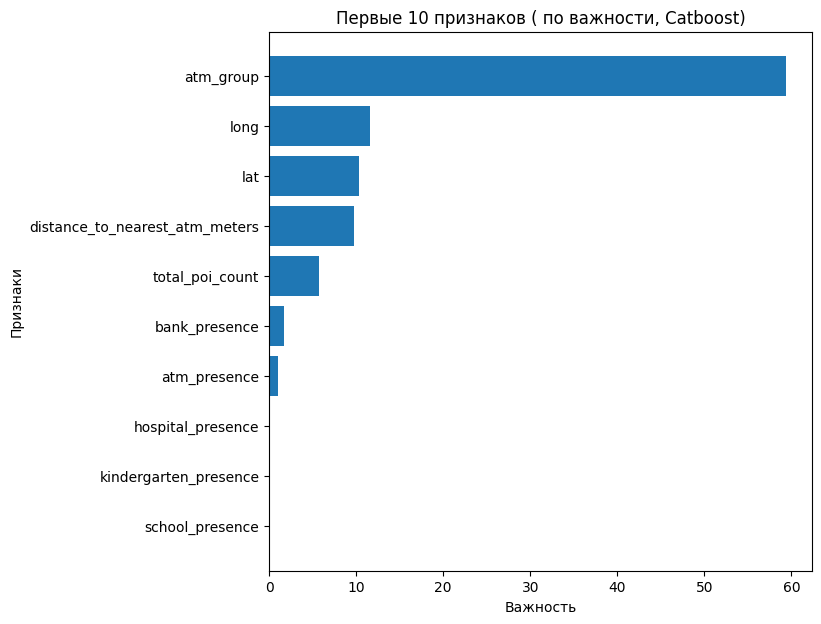

In [389]:
weights_plot(model.feature_importances_, X_train.columns, 10, 'Catboost')

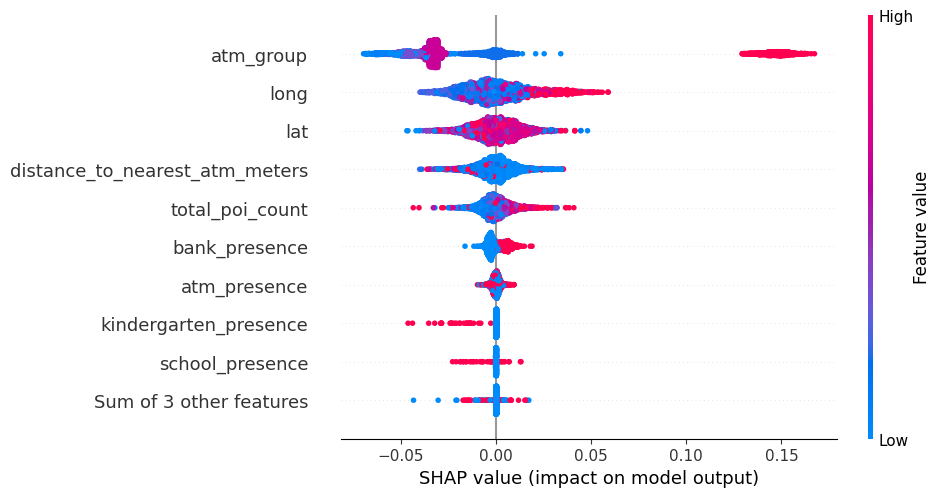

In [390]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

In [391]:
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from catboost import CatBoostRegressor
def objective_catboost(trial):
    depth = trial.suggest_int("depth", 2, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    iterations = trial.suggest_int("iterations", 10, 1000)

    score = cross_val_score(CatBoostRegressor(depth=depth, learning_rate=learning_rate, iterations=iterations, cat_features=categorical_features_indices),
                            X_train, y_train, cv=3, scoring='r2', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)

[I 2025-01-11 00:12:09,037] A new study created in memory with name: no-name-9fac3c14-d83f-47b4-a96b-aeeaae3b270e
[I 2025-01-11 00:12:10,726] Trial 0 finished with value: 0.6867408423990655 and parameters: {'depth': 3, 'learning_rate': 0.009084492305624576, 'iterations': 615}. Best is trial 0 with value: 0.6867408423990655.


0:	learn: 0.0854556	total: 57.2ms	remaining: 35.1s
1:	learn: 0.0849803	total: 57.7ms	remaining: 17.7s
2:	learn: 0.0845146	total: 58.1ms	remaining: 11.8s
3:	learn: 0.0840528	total: 58.6ms	remaining: 8.96s
4:	learn: 0.0835929	total: 59ms	remaining: 7.2s
5:	learn: 0.0831365	total: 59.3ms	remaining: 6.02s
6:	learn: 0.0826925	total: 59.7ms	remaining: 5.19s
7:	learn: 0.0822514	total: 60.2ms	remaining: 4.57s
8:	learn: 0.0818148	total: 60.5ms	remaining: 4.08s
9:	learn: 0.0813589	total: 61ms	remaining: 3.69s
10:	learn: 0.0809300	total: 61.4ms	remaining: 3.37s
11:	learn: 0.0805116	total: 61.9ms	remaining: 3.11s
12:	learn: 0.0800903	total: 62.5ms	remaining: 2.89s
13:	learn: 0.0796869	total: 62.8ms	remaining: 2.7s
14:	learn: 0.0792822	total: 63.3ms	remaining: 2.53s
15:	learn: 0.0788859	total: 63.6ms	remaining: 2.38s
16:	learn: 0.0784955	total: 64ms	remaining: 2.25s
17:	learn: 0.0781033	total: 64.3ms	remaining: 2.13s
18:	learn: 0.0777207	total: 64.7ms	remaining: 2.03s
19:	learn: 0.0773403	total: 65

[I 2025-01-11 00:12:11,585] Trial 1 finished with value: 0.7016490873159164 and parameters: {'depth': 3, 'learning_rate': 0.016957416506091103, 'iterations': 767}. Best is trial 1 with value: 0.7016490873159164.


0:	learn: 0.0853164	total: 56.9ms	remaining: 43.6s
1:	learn: 0.0844531	total: 57.3ms	remaining: 21.9s
2:	learn: 0.0836109	total: 57.7ms	remaining: 14.7s
3:	learn: 0.0827889	total: 58.1ms	remaining: 11.1s
4:	learn: 0.0819801	total: 58.6ms	remaining: 8.92s
5:	learn: 0.0811882	total: 59ms	remaining: 7.48s
6:	learn: 0.0804219	total: 59.4ms	remaining: 6.45s
7:	learn: 0.0796750	total: 59.8ms	remaining: 5.68s
8:	learn: 0.0789399	total: 60.2ms	remaining: 5.07s
9:	learn: 0.0781544	total: 61.3ms	remaining: 4.64s
10:	learn: 0.0774521	total: 61.5ms	remaining: 4.23s
11:	learn: 0.0767703	total: 61.9ms	remaining: 3.89s
12:	learn: 0.0760795	total: 62.2ms	remaining: 3.61s
13:	learn: 0.0754415	total: 62.5ms	remaining: 3.36s
14:	learn: 0.0748087	total: 62.8ms	remaining: 3.15s
15:	learn: 0.0741792	total: 63.1ms	remaining: 2.96s
16:	learn: 0.0735808	total: 63.4ms	remaining: 2.8s
17:	learn: 0.0729230	total: 63.7ms	remaining: 2.65s
18:	learn: 0.0723448	total: 64ms	remaining: 2.52s
19:	learn: 0.0717775	total:

[I 2025-01-11 00:12:12,555] Trial 2 finished with value: 0.7027033998710918 and parameters: {'depth': 8, 'learning_rate': 0.016050330511918783, 'iterations': 319}. Best is trial 2 with value: 0.7027033998710918.


0:	learn: 0.0853438	total: 57.8ms	remaining: 18.4s
1:	learn: 0.0845858	total: 59ms	remaining: 9.36s
2:	learn: 0.0837278	total: 60.1ms	remaining: 6.33s
3:	learn: 0.0829569	total: 61.4ms	remaining: 4.83s
4:	learn: 0.0821428	total: 62.7ms	remaining: 3.94s
5:	learn: 0.0814072	total: 63.9ms	remaining: 3.33s
6:	learn: 0.0806253	total: 65ms	remaining: 2.9s
7:	learn: 0.0799046	total: 65.3ms	remaining: 2.54s
8:	learn: 0.0792215	total: 66.4ms	remaining: 2.29s
9:	learn: 0.0785435	total: 67.5ms	remaining: 2.09s
10:	learn: 0.0778641	total: 68.7ms	remaining: 1.92s
11:	learn: 0.0772162	total: 69.8ms	remaining: 1.78s
12:	learn: 0.0765402	total: 70.8ms	remaining: 1.67s
13:	learn: 0.0758934	total: 71.9ms	remaining: 1.57s
14:	learn: 0.0752887	total: 72.9ms	remaining: 1.48s
15:	learn: 0.0746750	total: 73.6ms	remaining: 1.39s
16:	learn: 0.0740389	total: 74.5ms	remaining: 1.32s
17:	learn: 0.0734037	total: 76ms	remaining: 1.27s
18:	learn: 0.0728648	total: 76.9ms	remaining: 1.21s
19:	learn: 0.0722970	total: 7

[I 2025-01-11 00:12:13,345] Trial 3 finished with value: 0.5620605814470404 and parameters: {'depth': 7, 'learning_rate': 0.0029319885519148007, 'iterations': 343}. Best is trial 2 with value: 0.7027033998710918.


0:	learn: 0.0857767	total: 56.1ms	remaining: 19.2s
1:	learn: 0.0856246	total: 56.9ms	remaining: 9.71s
2:	learn: 0.0854816	total: 57.8ms	remaining: 6.54s
3:	learn: 0.0853309	total: 58.5ms	remaining: 4.96s
4:	learn: 0.0851692	total: 59.2ms	remaining: 4s
5:	learn: 0.0850148	total: 60ms	remaining: 3.37s
6:	learn: 0.0848621	total: 60.5ms	remaining: 2.9s
7:	learn: 0.0847165	total: 61.3ms	remaining: 2.57s
8:	learn: 0.0845673	total: 61.8ms	remaining: 2.29s
9:	learn: 0.0844236	total: 62.6ms	remaining: 2.08s
10:	learn: 0.0842841	total: 63.3ms	remaining: 1.91s
11:	learn: 0.0841281	total: 64.1ms	remaining: 1.77s
12:	learn: 0.0839854	total: 64.8ms	remaining: 1.64s
13:	learn: 0.0838322	total: 65.5ms	remaining: 1.54s
14:	learn: 0.0836888	total: 66.4ms	remaining: 1.45s
15:	learn: 0.0835437	total: 67ms	remaining: 1.37s
16:	learn: 0.0833975	total: 67.2ms	remaining: 1.29s
17:	learn: 0.0832539	total: 67.8ms	remaining: 1.22s
18:	learn: 0.0831067	total: 68.1ms	remaining: 1.16s
19:	learn: 0.0829694	total: 68

[I 2025-01-11 00:12:13,560] Trial 4 finished with value: 0.5576213705863341 and parameters: {'depth': 3, 'learning_rate': 0.0021243865527863595, 'iterations': 497}. Best is trial 2 with value: 0.7027033998710918.


131:	learn: 0.0739425	total: 47.5ms	remaining: 131ms
132:	learn: 0.0738657	total: 47.9ms	remaining: 131ms
133:	learn: 0.0737892	total: 48.2ms	remaining: 130ms
134:	learn: 0.0737116	total: 48.5ms	remaining: 130ms
135:	learn: 0.0736351	total: 48.7ms	remaining: 129ms
136:	learn: 0.0735582	total: 49.1ms	remaining: 129ms
137:	learn: 0.0734823	total: 49.5ms	remaining: 129ms
138:	learn: 0.0734066	total: 49.8ms	remaining: 128ms
139:	learn: 0.0733291	total: 50.2ms	remaining: 128ms
140:	learn: 0.0732549	total: 50.6ms	remaining: 128ms
141:	learn: 0.0731801	total: 51ms	remaining: 128ms
142:	learn: 0.0731055	total: 51.4ms	remaining: 127ms
143:	learn: 0.0730292	total: 51.8ms	remaining: 127ms
144:	learn: 0.0729544	total: 52.1ms	remaining: 127ms
145:	learn: 0.0728790	total: 52.5ms	remaining: 126ms
146:	learn: 0.0728040	total: 52.9ms	remaining: 126ms
147:	learn: 0.0727315	total: 53.3ms	remaining: 126ms
148:	learn: 0.0726590	total: 53.7ms	remaining: 125ms
149:	learn: 0.0725835	total: 54.2ms	remaining: 1

[I 2025-01-11 00:12:13,735] Trial 5 finished with value: 0.6466995265573839 and parameters: {'depth': 2, 'learning_rate': 0.005518068168912135, 'iterations': 527}. Best is trial 2 with value: 0.7027033998710918.
[I 2025-01-11 00:12:13,922] Trial 6 finished with value: 0.004882006425635484 and parameters: {'depth': 3, 'learning_rate': 1.1310908709548525e-05, 'iterations': 397}. Best is trial 2 with value: 0.7027033998710918.


317:	learn: 0.0495475	total: 180ms	remaining: 168ms
318:	learn: 0.0495341	total: 180ms	remaining: 167ms
319:	learn: 0.0495249	total: 180ms	remaining: 166ms
320:	learn: 0.0495164	total: 181ms	remaining: 165ms
321:	learn: 0.0495067	total: 181ms	remaining: 165ms
322:	learn: 0.0494951	total: 181ms	remaining: 164ms
323:	learn: 0.0494841	total: 182ms	remaining: 163ms
324:	learn: 0.0494652	total: 182ms	remaining: 162ms
325:	learn: 0.0494578	total: 182ms	remaining: 161ms
326:	learn: 0.0494499	total: 182ms	remaining: 161ms
327:	learn: 0.0494395	total: 183ms	remaining: 160ms
328:	learn: 0.0494284	total: 183ms	remaining: 159ms
329:	learn: 0.0494166	total: 183ms	remaining: 158ms
330:	learn: 0.0494048	total: 184ms	remaining: 158ms
331:	learn: 0.0493893	total: 184ms	remaining: 157ms
332:	learn: 0.0493712	total: 184ms	remaining: 156ms
333:	learn: 0.0493611	total: 185ms	remaining: 155ms
334:	learn: 0.0493517	total: 185ms	remaining: 155ms
335:	learn: 0.0493394	total: 185ms	remaining: 154ms
336:	learn: 

[I 2025-01-11 00:12:14,117] Trial 7 finished with value: 0.6632429818028767 and parameters: {'depth': 3, 'learning_rate': 0.6457619952762156, 'iterations': 401}. Best is trial 2 with value: 0.7027033998710918.


s
307:	learn: 0.0857485	total: 114ms	remaining: 32.9ms
308:	learn: 0.0857479	total: 114ms	remaining: 32.5ms
309:	learn: 0.0857473	total: 115ms	remaining: 32.2ms
310:	learn: 0.0857467	total: 115ms	remaining: 31.8ms
172:	learn: 0.0860962	total: 68.7ms	remaining: 88.9ms
173:	learn: 0.0860956	total: 69.1ms	remaining: 88.6ms
174:	learn: 0.0860950	total: 69.5ms	remaining: 88.1ms
175:	learn: 0.0860944	total: 69.7ms	remaining: 87.6ms
176:	learn: 0.0860938	total: 70ms	remaining: 87ms
177:	learn: 0.0860932	total: 70.3ms	remaining: 86.5ms
178:	learn: 0.0860926	total: 70.6ms	remaining: 86ms
179:	learn: 0.0860920	total: 71.1ms	remaining: 85.7ms
180:	learn: 0.0860915	total: 71.6ms	remaining: 85.4ms
181:	learn: 0.0860909	total: 72ms	remaining: 85ms
182:	learn: 0.0860903	total: 72.4ms	remaining: 84.6ms
183:	learn: 0.0860897	total: 72.7ms	remaining: 84.2ms
184:	learn: 0.0860891	total: 73.1ms	remaining: 83.8ms
185:	learn: 0.0860885	total: 73.6ms	remaining: 83.5ms
186:	learn: 0.0860879	total: 74.1ms	rema

[I 2025-01-11 00:12:14,256] Trial 8 finished with value: 0.2644457456712078 and parameters: {'depth': 4, 'learning_rate': 0.001170830902147361, 'iterations': 237}. Best is trial 2 with value: 0.7027033998710918.


223:	learn: 0.0863797	total: 87.3ms	remaining: 67.4ms
224:	learn: 0.0863790	total: 87.7ms	remaining: 67.1ms
225:	learn: 0.0863784	total: 88.1ms	remaining: 66.7ms
226:	learn: 0.0863778	total: 88.4ms	remaining: 66.2ms
227:	learn: 0.0863772	total: 88.6ms	remaining: 65.7ms
228:	learn: 0.0863766	total: 88.9ms	remaining: 65.3ms
229:	learn: 0.0863760	total: 89.3ms	remaining: 64.9ms
230:	learn: 0.0863754	total: 89.8ms	remaining: 64.5ms
231:	learn: 0.0863748	total: 90.2ms	remaining: 64.2ms
232:	learn: 0.0863742	total: 90.6ms	remaining: 63.7ms
233:	learn: 0.0863736	total: 90.8ms	remaining: 63.3ms
234:	learn: 0.0863730	total: 91.3ms	remaining: 62.9ms
235:	learn: 0.0863724	total: 91.7ms	remaining: 62.6ms
236:	learn: 0.0863718	total: 92ms	remaining: 62.1ms
237:	learn: 0.0863712	total: 92.3ms	remaining: 61.7ms
238:	learn: 0.0863705	total: 92.6ms	remaining: 61.2ms
239:	learn: 0.0863699	total: 93ms	remaining: 60.8ms
240:	learn: 0.0863693	total: 93.3ms	remaining: 60.4ms
241:	learn: 0.0863687	total: 93.

[I 2025-01-11 00:12:14,696] Trial 9 finished with value: 0.009385566915078228 and parameters: {'depth': 6, 'learning_rate': 1.573228106899075e-05, 'iterations': 527}. Best is trial 2 with value: 0.7027033998710918.


214:	learn: 0.0863358	total: 163ms	remaining: 237ms
215:	learn: 0.0863349	total: 164ms	remaining: 236ms
216:	learn: 0.0863341	total: 165ms	remaining: 235ms
217:	learn: 0.0863332	total: 165ms	remaining: 234ms
218:	learn: 0.0863324	total: 166ms	remaining: 233ms
219:	learn: 0.0863315	total: 166ms	remaining: 232ms
220:	learn: 0.0863307	total: 167ms	remaining: 231ms
221:	learn: 0.0863299	total: 167ms	remaining: 229ms
222:	learn: 0.0863290	total: 168ms	remaining: 228ms
223:	learn: 0.0863282	total: 169ms	remaining: 228ms
224:	learn: 0.0863274	total: 169ms	remaining: 227ms
225:	learn: 0.0863265	total: 170ms	remaining: 227ms
226:	learn: 0.0863256	total: 171ms	remaining: 226ms
227:	learn: 0.0863248	total: 172ms	remaining: 225ms
228:	learn: 0.0863240	total: 173ms	remaining: 225ms
229:	learn: 0.0863232	total: 173ms	remaining: 224ms
230:	learn: 0.0863223	total: 174ms	remaining: 223ms
231:	learn: 0.0863215	total: 175ms	remaining: 222ms
232:	learn: 0.0863207	total: 176ms	remaining: 222ms
233:	learn: 

[I 2025-01-11 00:12:19,226] Trial 10 finished with value: 0.6719739442649826 and parameters: {'depth': 10, 'learning_rate': 0.15187898815492548, 'iterations': 982}. Best is trial 2 with value: 0.7027033998710918.


298:	learn: 0.0856870	total: 226ms	remaining: 173ms
299:	learn: 0.0856862	total: 227ms	remaining: 172ms
300:	learn: 0.0856853	total: 228ms	remaining: 171ms
301:	learn: 0.0856845	total: 229ms	remaining: 170ms
302:	learn: 0.0856837	total: 229ms	remaining: 170ms
303:	learn: 0.0856829	total: 230ms	remaining: 169ms
304:	learn: 0.0856821	total: 231ms	remaining: 168ms
305:	learn: 0.0856813	total: 232ms	remaining: 167ms
306:	learn: 0.0856805	total: 233ms	remaining: 167ms
307:	learn: 0.0856797	total: 233ms	remaining: 166ms
308:	learn: 0.0856788	total: 234ms	remaining: 165ms
309:	learn: 0.0856780	total: 235ms	remaining: 164ms
310:	learn: 0.0856772	total: 235ms	remaining: 163ms
311:	learn: 0.0856764	total: 236ms	remaining: 163ms
312:	learn: 0.0856756	total: 237ms	remaining: 162ms
313:	learn: 0.0856747	total: 237ms	remaining: 161ms
314:	learn: 0.0856739	total: 238ms	remaining: 160ms
315:	learn: 0.0856731	total: 239ms	remaining: 159ms
316:	learn: 0.0856723	total: 240ms	remaining: 159ms
317:	learn: 

[I 2025-01-11 00:12:20,582] Trial 11 finished with value: 0.7037721009461059 and parameters: {'depth': 8, 'learning_rate': 0.05150205749721059, 'iterations': 791}. Best is trial 11 with value: 0.7037721009461059.


403:	learn: 0.0339387	total: 660ms	remaining: 632ms
404:	learn: 0.0339106	total: 661ms	remaining: 630ms
405:	learn: 0.0338751	total: 663ms	remaining: 628ms
406:	learn: 0.0338580	total: 664ms	remaining: 627ms
407:	learn: 0.0338340	total: 666ms	remaining: 625ms
408:	learn: 0.0338034	total: 668ms	remaining: 623ms
409:	learn: 0.0337782	total: 669ms	remaining: 622ms
410:	learn: 0.0337554	total: 671ms	remaining: 620ms
411:	learn: 0.0337315	total: 673ms	remaining: 619ms
412:	learn: 0.0337099	total: 674ms	remaining: 617ms
413:	learn: 0.0336809	total: 676ms	remaining: 615ms
414:	learn: 0.0336644	total: 677ms	remaining: 614ms
415:	learn: 0.0336506	total: 679ms	remaining: 612ms
416:	learn: 0.0336450	total: 681ms	remaining: 610ms
417:	learn: 0.0336219	total: 682ms	remaining: 609ms
418:	learn: 0.0335920	total: 684ms	remaining: 607ms
419:	learn: 0.0335529	total: 685ms	remaining: 605ms
420:	learn: 0.0335157	total: 687ms	remaining: 604ms
421:	learn: 0.0335027	total: 689ms	remaining: 602ms
422:	learn: 

[I 2025-01-11 00:12:21,169] Trial 12 finished with value: 0.6505397447930065 and parameters: {'depth': 9, 'learning_rate': 0.06068299593949039, 'iterations': 28}. Best is trial 11 with value: 0.7037721009461059.


258:	learn: 0.0551552	total: 76.1ms	remaining: 78.7ms
259:	learn: 0.0551277	total: 76.3ms	remaining: 78.3ms
260:	learn: 0.0550951	total: 76.5ms	remaining: 77.9ms
261:	learn: 0.0550629	total: 76.7ms	remaining: 77.6ms
262:	learn: 0.0550308	total: 76.9ms	remaining: 77.2ms
263:	learn: 0.0549991	total: 77.1ms	remaining: 76.8ms
264:	learn: 0.0549678	total: 77.4ms	remaining: 76.5ms
265:	learn: 0.0549366	total: 77.7ms	remaining: 76.2ms
266:	learn: 0.0549100	total: 78ms	remaining: 76ms
267:	learn: 0.0548820	total: 78.3ms	remaining: 75.7ms
268:	learn: 0.0548530	total: 78.6ms	remaining: 75.4ms
269:	learn: 0.0548268	total: 78.8ms	remaining: 75ms
270:	learn: 0.0547983	total: 79.1ms	remaining: 74.8ms
271:	learn: 0.0547706	total: 79.5ms	remaining: 74.5ms
272:	learn: 0.0547442	total: 79.8ms	remaining: 74.3ms
273:	learn: 0.0547167	total: 80.2ms	remaining: 74ms
274:	learn: 0.0546917	total: 80.4ms	remaining: 73.7ms
275:	learn: 0.0546666	total: 80.8ms	remaining: 73.4ms
276:	learn: 0.0546426	total: 81ms	re

[I 2025-01-11 00:12:22,478] Trial 13 finished with value: 0.33085944676913304 and parameters: {'depth': 8, 'learning_rate': 0.0004788480801425456, 'iterations': 798}. Best is trial 11 with value: 0.7037721009461059.
[I 2025-01-11 00:12:22,636] Trial 14 finished with value: 0.7067397431600634 and parameters: {'depth': 6, 'learning_rate': 0.07133222432257491, 'iterations': 157}. Best is trial 14 with value: 0.7067397431600634.
[I 2025-01-11 00:12:22,690] Trial 15 finished with value: 0.6789619056496244 and parameters: {'depth': 6, 'learning_rate': 0.727896934400361, 'iterations': 43}. Best is trial 14 with value: 0.7067397431600634.


517:	learn: 0.0748236	total: 733ms	remaining: 396ms
518:	learn: 0.0748053	total: 734ms	remaining: 395ms
519:	learn: 0.0747882	total: 735ms	remaining: 393ms
520:	learn: 0.0747713	total: 737ms	remaining: 392ms
521:	learn: 0.0747530	total: 738ms	remaining: 390ms
522:	learn: 0.0747333	total: 740ms	remaining: 389ms
523:	learn: 0.0747154	total: 742ms	remaining: 388ms
524:	learn: 0.0746977	total: 743ms	remaining: 387ms
525:	learn: 0.0746800	total: 745ms	remaining: 385ms
526:	learn: 0.0746619	total: 747ms	remaining: 384ms
527:	learn: 0.0746433	total: 748ms	remaining: 383ms
528:	learn: 0.0746255	total: 750ms	remaining: 381ms
529:	learn: 0.0746064	total: 751ms	remaining: 380ms
530:	learn: 0.0745885	total: 753ms	remaining: 379ms
531:	learn: 0.0745709	total: 755ms	remaining: 377ms
532:	learn: 0.0745532	total: 756ms	remaining: 376ms
533:	learn: 0.0745354	total: 758ms	remaining: 375ms
534:	learn: 0.0745178	total: 759ms	remaining: 373ms
535:	learn: 0.0744992	total: 760ms	remaining: 372ms
536:	learn: 

[I 2025-01-11 00:12:22,831] Trial 16 finished with value: 0.7099147552844373 and parameters: {'depth': 5, 'learning_rate': 0.11562048257668947, 'iterations': 195}. Best is trial 16 with value: 0.7099147552844373.


0:	learn: 0.0829937	total: 57.2ms	remaining: 1.54s
1:	learn: 0.0803205	total: 59.6ms	remaining: 775ms
2:	learn: 0.0777446	total: 61.5ms	remaining: 512ms
3:	learn: 0.0751703	total: 63.3ms	remaining: 380ms
4:	learn: 0.0726520	total: 65ms	remaining: 299ms
5:	learn: 0.0703322	total: 66.5ms	remaining: 244ms
6:	learn: 0.0683031	total: 68.3ms	remaining: 205ms
7:	learn: 0.0664072	total: 69.9ms	remaining: 175ms
8:	learn: 0.0647468	total: 70.3ms	remaining: 148ms
9:	learn: 0.0632780	total: 71.9ms	remaining: 129ms
10:	learn: 0.0619372	total: 73.4ms	remaining: 113ms
11:	learn: 0.0606086	total: 75ms	remaining: 99.9ms
12:	learn: 0.0594256	total: 76.5ms	remaining: 88.3ms
13:	learn: 0.0581897	total: 78.1ms	remaining: 78.1ms
14:	learn: 0.0572158	total: 79ms	remaining: 68.5ms
15:	learn: 0.0563258	total: 80.6ms	remaining: 60.4ms
16:	learn: 0.0555386	total: 82ms	remaining: 53.1ms
17:	learn: 0.0548217	total: 82.2ms	remaining: 45.7ms
18:	learn: 0.0539326	total: 83.9ms	remaining: 39.7ms
19:	learn: 0.0531397	t

[I 2025-01-11 00:12:23,003] Trial 17 finished with value: 0.701728267859667 and parameters: {'depth': 5, 'learning_rate': 0.21804290155861464, 'iterations': 170}. Best is trial 16 with value: 0.7099147552844373.
[I 2025-01-11 00:12:23,130] Trial 18 finished with value: 0.03209015339463469 and parameters: {'depth': 5, 'learning_rate': 0.00021071863437192466, 'iterations': 130}. Best is trial 16 with value: 0.7099147552844373.


35:	learn: 0.0474930	total: 30.8ms	remaining: 103ms
36:	learn: 0.0473805	total: 31.7ms	remaining: 103ms
37:	learn: 0.0472832	total: 32.8ms	remaining: 103ms
38:	learn: 0.0471182	total: 33.8ms	remaining: 102ms
39:	learn: 0.0469953	total: 35.5ms	remaining: 104ms
40:	learn: 0.0468682	total: 36.9ms	remaining: 104ms
41:	learn: 0.0467784	total: 37.7ms	remaining: 103ms
42:	learn: 0.0466615	total: 38.6ms	remaining: 102ms
43:	learn: 0.0466019	total: 39.4ms	remaining: 101ms
44:	learn: 0.0465253	total: 40.2ms	remaining: 100ms
45:	learn: 0.0464439	total: 41.2ms	remaining: 99.4ms
46:	learn: 0.0463742	total: 42ms	remaining: 98.2ms
47:	learn: 0.0463342	total: 42.9ms	remaining: 97.5ms
48:	learn: 0.0462417	total: 43.9ms	remaining: 96.8ms
49:	learn: 0.0461869	total: 44.8ms	remaining: 95.9ms
50:	learn: 0.0461051	total: 45.7ms	remaining: 94.9ms
51:	learn: 0.0460360	total: 46.5ms	remaining: 93.9ms
52:	learn: 0.0459455	total: 47.3ms	remaining: 92.9ms
53:	learn: 0.0458835	total: 48.2ms	remaining: 92ms
54:	lea

[I 2025-01-11 00:12:23,323] Trial 19 finished with value: 0.7083916476608053 and parameters: {'depth': 5, 'learning_rate': 0.05762441255897524, 'iterations': 237}. Best is trial 16 with value: 0.7099147552844373.


83:	learn: 0.0410775	total: 52.9ms	remaining: 54.2ms
84:	learn: 0.0409741	total: 53.6ms	remaining: 53.6ms
85:	learn: 0.0409057	total: 54.3ms	remaining: 53.1ms
86:	learn: 0.0408505	total: 54.9ms	remaining: 52.4ms
87:	learn: 0.0408026	total: 55.4ms	remaining: 51.6ms
88:	learn: 0.0407711	total: 56.1ms	remaining: 51ms
89:	learn: 0.0407052	total: 56.7ms	remaining: 50.4ms
90:	learn: 0.0406074	total: 57.3ms	remaining: 49.8ms
91:	learn: 0.0405503	total: 57.9ms	remaining: 49.1ms
92:	learn: 0.0405261	total: 58.5ms	remaining: 48.5ms
93:	learn: 0.0404360	total: 59ms	remaining: 47.7ms
94:	learn: 0.0403241	total: 59.8ms	remaining: 47.2ms
95:	learn: 0.0402659	total: 60.2ms	remaining: 46.4ms
96:	learn: 0.0402156	total: 60.8ms	remaining: 45.8ms
97:	learn: 0.0401806	total: 61.5ms	remaining: 45.2ms
98:	learn: 0.0401337	total: 62.2ms	remaining: 44.6ms
99:	learn: 0.0401023	total: 62.8ms	remaining: 44ms
100:	learn: 0.0400553	total: 63.5ms	remaining: 43.4ms
101:	learn: 0.0400174	total: 64.1ms	remaining: 42.7

[I 2025-01-11 00:12:23,546] Trial 20 finished with value: 0.6943521126170887 and parameters: {'depth': 5, 'learning_rate': 0.291044652562847, 'iterations': 264}. Best is trial 16 with value: 0.7099147552844373.


95:	learn: 0.0456304	total: 67.8ms	remaining: 99.6ms
96:	learn: 0.0456144	total: 68.5ms	remaining: 98.9ms
97:	learn: 0.0455780	total: 69.3ms	remaining: 98.3ms
98:	learn: 0.0455514	total: 69.9ms	remaining: 97.5ms
99:	learn: 0.0455438	total: 70.2ms	remaining: 96.2ms
100:	learn: 0.0454991	total: 70.8ms	remaining: 95.3ms
101:	learn: 0.0454775	total: 71.3ms	remaining: 94.3ms
102:	learn: 0.0454613	total: 71.9ms	remaining: 93.5ms
103:	learn: 0.0454281	total: 72.4ms	remaining: 92.6ms
104:	learn: 0.0454063	total: 73.1ms	remaining: 91.8ms
105:	learn: 0.0453801	total: 73.7ms	remaining: 91ms
106:	learn: 0.0453478	total: 74.3ms	remaining: 90.3ms
107:	learn: 0.0453292	total: 75ms	remaining: 89.6ms
108:	learn: 0.0453093	total: 75.6ms	remaining: 88.8ms
109:	learn: 0.0452918	total: 76.3ms	remaining: 88.1ms
110:	learn: 0.0452788	total: 76.8ms	remaining: 87.2ms
111:	learn: 0.0452605	total: 77.4ms	remaining: 86.4ms
112:	learn: 0.0452235	total: 77.9ms	remaining: 85.5ms
113:	learn: 0.0452029	total: 78.5ms	r

[I 2025-01-11 00:12:23,811] Trial 21 finished with value: 0.7087876548005894 and parameters: {'depth': 7, 'learning_rate': 0.060906911835058, 'iterations': 153}. Best is trial 16 with value: 0.7099147552844373.
[I 2025-01-11 00:12:23,929] Trial 22 finished with value: 0.6729201831871032 and parameters: {'depth': 7, 'learning_rate': 0.028919072826257136, 'iterations': 77}. Best is trial 16 with value: 0.7099147552844373.


622:	learn: 0.0293281	total: 1s	remaining: 270ms
623:	learn: 0.0293111	total: 1s	remaining: 269ms
624:	learn: 0.0292818	total: 1s	remaining: 267ms
625:	learn: 0.0292677	total: 1.01s	remaining: 265ms
626:	learn: 0.0292484	total: 1.01s	remaining: 264ms
627:	learn: 0.0292381	total: 1.01s	remaining: 262ms
628:	learn: 0.0292142	total: 1.01s	remaining: 260ms
629:	learn: 0.0292026	total: 1.01s	remaining: 259ms
630:	learn: 0.0291885	total: 1.01s	remaining: 257ms
631:	learn: 0.0291779	total: 1.02s	remaining: 256ms
632:	learn: 0.0291714	total: 1.02s	remaining: 254ms
633:	learn: 0.0291561	total: 1.02s	remaining: 253ms
634:	learn: 0.0291462	total: 1.02s	remaining: 251ms
635:	learn: 0.0291252	total: 1.02s	remaining: 249ms
636:	learn: 0.0291048	total: 1.02s	remaining: 248ms
637:	learn: 0.0290958	total: 1.02s	remaining: 246ms
638:	learn: 0.0290754	total: 1.03s	remaining: 244ms
639:	learn: 0.0290576	total: 1.03s	remaining: 243ms
640:	learn: 0.0290444	total: 1.03s	remaining: 241ms
641:	learn: 0.0290259

[I 2025-01-11 00:12:24,243] Trial 23 finished with value: 0.706341979079849 and parameters: {'depth': 7, 'learning_rate': 0.13680301825546137, 'iterations': 233}. Best is trial 16 with value: 0.7099147552844373.


772:	learn: 0.0095267	total: 3.42s	remaining: 924ms
773:	learn: 0.0095204	total: 3.42s	remaining: 919ms
774:	learn: 0.0095065	total: 3.42s	remaining: 915ms
775:	learn: 0.0094913	total: 3.43s	remaining: 910ms
776:	learn: 0.0094807	total: 3.43s	remaining: 906ms
777:	learn: 0.0094678	total: 3.44s	remaining: 902ms
778:	learn: 0.0094574	total: 3.44s	remaining: 897ms
779:	learn: 0.0094514	total: 3.45s	remaining: 893ms
780:	learn: 0.0094361	total: 3.45s	remaining: 888ms
781:	learn: 0.0094356	total: 3.45s	remaining: 883ms
782:	learn: 0.0094232	total: 3.46s	remaining: 879ms
783:	learn: 0.0094063	total: 3.46s	remaining: 874ms
784:	learn: 0.0093996	total: 3.46s	remaining: 870ms
785:	learn: 0.0093909	total: 3.47s	remaining: 865ms
786:	learn: 0.0093856	total: 3.47s	remaining: 861ms
787:	learn: 0.0093766	total: 3.48s	remaining: 856ms
788:	learn: 0.0093628	total: 3.48s	remaining: 852ms
789:	learn: 0.0093537	total: 3.49s	remaining: 847ms
790:	learn: 0.0093464	total: 3.49s	remaining: 843ms
791:	learn: 

[I 2025-01-11 00:12:24,345] Trial 24 finished with value: 0.7000222739623202 and parameters: {'depth': 4, 'learning_rate': 0.3520629220827736, 'iterations': 145}. Best is trial 16 with value: 0.7099147552844373.


930:	learn: 0.0082776	total: 4.13s	remaining: 226ms
931:	learn: 0.0082712	total: 4.14s	remaining: 222ms
932:	learn: 0.0082640	total: 4.14s	remaining: 217ms
933:	learn: 0.0082609	total: 4.14s	remaining: 213ms
934:	learn: 0.0082554	total: 4.15s	remaining: 209ms
935:	learn: 0.0082464	total: 4.15s	remaining: 204ms
936:	learn: 0.0082404	total: 4.16s	remaining: 200ms
937:	learn: 0.0082350	total: 4.16s	remaining: 195ms
938:	learn: 0.0082301	total: 4.16s	remaining: 191ms
939:	learn: 0.0082219	total: 4.17s	remaining: 186ms
940:	learn: 0.0082149	total: 4.17s	remaining: 182ms
941:	learn: 0.0082106	total: 4.18s	remaining: 177ms
942:	learn: 0.0082018	total: 4.18s	remaining: 173ms
943:	learn: 0.0081945	total: 4.19s	remaining: 169ms
944:	learn: 0.0081884	total: 4.19s	remaining: 164ms
945:	learn: 0.0081819	total: 4.19s	remaining: 160ms
946:	learn: 0.0081707	total: 4.2s	remaining: 155ms
947:	learn: 0.0081678	total: 4.2s	remaining: 151ms
948:	learn: 0.0081611	total: 4.21s	remaining: 146ms
949:	learn: 0.

[I 2025-01-11 00:12:24,559] Trial 25 finished with value: 0.7073707492200532 and parameters: {'depth': 5, 'learning_rate': 0.0418633473493475, 'iterations': 293}. Best is trial 16 with value: 0.7099147552844373.


2:	learn: 0.0557704	total: 1.56ms	remaining: 74ms
3:	learn: 0.0521729	total: 2.07ms	remaining: 73ms
4:	learn: 0.0505020	total: 2.65ms	remaining: 74.3ms
5:	learn: 0.0493428	total: 3.16ms	remaining: 73.1ms
6:	learn: 0.0487679	total: 3.57ms	remaining: 70.5ms
7:	learn: 0.0483775	total: 3.94ms	remaining: 67.5ms
8:	learn: 0.0480038	total: 4.31ms	remaining: 65.1ms
9:	learn: 0.0475920	total: 4.77ms	remaining: 64.3ms
10:	learn: 0.0472916	total: 5.13ms	remaining: 62.5ms
11:	learn: 0.0471032	total: 5.44ms	remaining: 60.3ms
12:	learn: 0.0469751	total: 5.77ms	remaining: 58.6ms
13:	learn: 0.0467828	total: 6.14ms	remaining: 57.4ms
14:	learn: 0.0464591	total: 6.76ms	remaining: 58.6ms
15:	learn: 0.0463461	total: 7.31ms	remaining: 59ms
16:	learn: 0.0462051	total: 7.78ms	remaining: 58.5ms
17:	learn: 0.0460363	total: 8.3ms	remaining: 58.5ms
18:	learn: 0.0458348	total: 9.02ms	remaining: 59.8ms
19:	learn: 0.0456666	total: 9.56ms	remaining: 59.8ms
20:	learn: 0.0456007	total: 10ms	remaining: 59.1ms
21:	learn:

[I 2025-01-11 00:12:24,808] Trial 26 finished with value: 0.6926319335873931 and parameters: {'depth': 4, 'learning_rate': 0.013546187802751868, 'iterations': 420}. Best is trial 16 with value: 0.7099147552844373.


.0695047	total: 15.4ms	remaining: 200ms
30:	learn: 0.0690550	total: 16.1ms	remaining: 202ms
31:	learn: 0.0686525	total: 16.9ms	remaining: 204ms
32:	learn: 0.0682538	total: 17.6ms	remaining: 207ms
218:	learn: 0.0443739	total: 136ms	remaining: 46ms
219:	learn: 0.0443520	total: 137ms	remaining: 45.4ms
220:	learn: 0.0443414	total: 137ms	remaining: 44.8ms
221:	learn: 0.0443304	total: 138ms	remaining: 44.1ms
222:	learn: 0.0443177	total: 139ms	remaining: 43.5ms
223:	learn: 0.0442969	total: 139ms	remaining: 42.8ms
224:	learn: 0.0442865	total: 140ms	remaining: 42.2ms
225:	learn: 0.0442688	total: 140ms	remaining: 41.6ms
226:	learn: 0.0442598	total: 141ms	remaining: 41ms
227:	learn: 0.0442440	total: 142ms	remaining: 40.3ms
228:	learn: 0.0442295	total: 142ms	remaining: 39.7ms
229:	learn: 0.0442148	total: 143ms	remaining: 39.1ms
230:	learn: 0.0441933	total: 144ms	remaining: 38.5ms
231:	learn: 0.0441812	total: 144ms	remaining: 37.9ms
232:	learn: 0.0441568	total: 145ms	remaining: 37.3ms
233:	learn: 0

[I 2025-01-11 00:12:25,010] Trial 27 finished with value: 0.7082091960770794 and parameters: {'depth': 6, 'learning_rate': 0.1116779505588443, 'iterations': 205}. Best is trial 16 with value: 0.7099147552844373.


194:	learn: 0.0494085	total: 94.5ms	remaining: 109ms
195:	learn: 0.0493858	total: 94.8ms	remaining: 108ms
196:	learn: 0.0493724	total: 95.1ms	remaining: 108ms
197:	learn: 0.0493426	total: 95.4ms	remaining: 107ms
198:	learn: 0.0493096	total: 95.8ms	remaining: 106ms
199:	learn: 0.0492855	total: 96.1ms	remaining: 106ms
200:	learn: 0.0492656	total: 96.4ms	remaining: 105ms
201:	learn: 0.0492434	total: 96.8ms	remaining: 104ms
202:	learn: 0.0492192	total: 97.3ms	remaining: 104ms
203:	learn: 0.0491931	total: 97.6ms	remaining: 103ms
204:	learn: 0.0491704	total: 97.9ms	remaining: 103ms
205:	learn: 0.0491555	total: 98.3ms	remaining: 102ms
206:	learn: 0.0491400	total: 98.7ms	remaining: 102ms
207:	learn: 0.0491228	total: 99.1ms	remaining: 101ms
208:	learn: 0.0491048	total: 99.4ms	remaining: 100ms
209:	learn: 0.0490871	total: 99.8ms	remaining: 99.8ms
210:	learn: 0.0490765	total: 100ms	remaining: 99.2ms
211:	learn: 0.0490651	total: 101ms	remaining: 98.7ms
212:	learn: 0.0490463	total: 101ms	remaining:

[I 2025-01-11 00:12:25,141] Trial 28 finished with value: 0.42899189797031795 and parameters: {'depth': 7, 'learning_rate': 0.005698940523631208, 'iterations': 100}. Best is trial 16 with value: 0.7099147552844373.
[I 2025-01-11 00:12:25,170] Trial 29 finished with value: 0.6896860762279088 and parameters: {'depth': 2, 'learning_rate': 0.8947403662213917, 'iterations': 16}. Best is trial 16 with value: 0.7099147552844373.


302:	learn: 0.0536670	total: 88.2ms	remaining: 65.2ms
303:	learn: 0.0536463	total: 88.5ms	remaining: 64.9ms
304:	learn: 0.0536265	total: 88.7ms	remaining: 64.6ms
305:	learn: 0.0536063	total: 88.9ms	remaining: 64.2ms
306:	learn: 0.0535862	total: 89.1ms	remaining: 63.9ms
307:	learn: 0.0535663	total: 89.4ms	remaining: 63.6ms
308:	learn: 0.0535465	total: 89.6ms	remaining: 63.2ms
309:	learn: 0.0535277	total: 89.9ms	remaining: 62.9ms
310:	learn: 0.0535084	total: 90.1ms	remaining: 62.6ms
311:	learn: 0.0534874	total: 90.3ms	remaining: 62.2ms
312:	learn: 0.0534675	total: 90.6ms	remaining: 61.9ms
313:	learn: 0.0534484	total: 90.9ms	remaining: 61.7ms
314:	learn: 0.0534306	total: 91.1ms	remaining: 61.3ms
315:	learn: 0.0534122	total: 91.3ms	remaining: 61ms
316:	learn: 0.0533928	total: 91.6ms	remaining: 60.7ms
317:	learn: 0.0533754	total: 91.9ms	remaining: 60.4ms
318:	learn: 0.0533578	total: 92.2ms	remaining: 60.1ms
319:	learn: 0.0533402	total: 92.5ms	remaining: 59.9ms
320:	learn: 0.0533230	total: 9

In [392]:
model = CatBoostRegressor(**study.best_params)

model.fit(X_train, y_train, cat_features=categorical_features_indices)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')

0:	learn: 0.0801407	total: 2.15ms	remaining: 417ms
1:	learn: 0.0751597	total: 3.42ms	remaining: 330ms
2:	learn: 0.0708275	total: 4.52ms	remaining: 289ms
3:	learn: 0.0672397	total: 5.2ms	remaining: 248ms
4:	learn: 0.0643269	total: 6.17ms	remaining: 235ms
5:	learn: 0.0614996	total: 6.81ms	remaining: 215ms
6:	learn: 0.0592980	total: 7.63ms	remaining: 205ms
7:	learn: 0.0573325	total: 8.53ms	remaining: 199ms
8:	learn: 0.0558204	total: 9.46ms	remaining: 196ms
9:	learn: 0.0545989	total: 10.4ms	remaining: 193ms
10:	learn: 0.0537264	total: 11.2ms	remaining: 188ms
11:	learn: 0.0526937	total: 11.9ms	remaining: 182ms
12:	learn: 0.0519854	total: 12.5ms	remaining: 175ms
13:	learn: 0.0515126	total: 13.1ms	remaining: 170ms
14:	learn: 0.0510788	total: 13.9ms	remaining: 167ms
15:	learn: 0.0506616	total: 14.7ms	remaining: 165ms
16:	learn: 0.0503151	total: 15.5ms	remaining: 162ms
17:	learn: 0.0498308	total: 16.6ms	remaining: 163ms
18:	learn: 0.0495638	total: 17.3ms	remaining: 160ms
19:	learn: 0.0492112	to

In [394]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(categorical_feature=categorical_features_indices)


model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')

categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 4169, number of used features: 11
[LightGBM] [Info] Start training from score 0.000550
MSE для трейна равно 0.0013
MSE для теста равно 0.0021
RMSE для трейна равно 0.0359
RMSE для теста равно 0.0459
r2 для трейна равно 0.8261604116
r2 для теста равно 0.7162952774


In [396]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'num_leaves': list(range(31, 40)),
    "max_depth": [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5],
    'colsample_bytree': [0.8, 1],
    'subsample_for_bin': [150000,200000]
}


param_grid = {
    'num_leaves': list(range(35, 50)),
    "max_depth": [20, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5],
    'colsample_bytree': [0.8, 1],
    'subsample_for_bin': [150000,200000]
}


lgbm = LGBMRegressor()  # Instantiate the LGBMRegressor

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_sc, y_train)

# Obtain the best parameters and instantiate the model with the best parameters
best_params = grid_search.best_params_
lgbm_tuned = LGBMRegressor(**best_params)

# Train the tuned LGBMRegressor model on the training data
lgbm_tuned.fit(X_train_sc, y_train)

y_test_pred = lgbm_tuned.predict(X_test_sc)  # Predicting X_test to find the solution
score = round(r2_score(y_test, y_test_pred), 6)  # Find the R2 score of y_test and predictions

print(score)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 3335, number of used features: 11
[LightGBM] [Info] Start training from score -0.000387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 855
[LightGBM] [Info] Number of data points in the train set: 3335, number of used features: 11
[LightGBM] [Info] Start training from score -0.000116
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [398]:
pred_train = lgbm_tuned.predict(X_train_sc)
pred_test = model.predict(X_test_sc)

mse_train = mean_squared_error(y_train, pred_train)
mse_test = mean_squared_error(y_test, pred_test)

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(f'MSE для трейна равно {mse_train:.4f}')
print(f'MSE для теста равно {mse_test:.4f}')

print(f'RMSE для трейна равно {rmse_train:.4f}')
print(f'RMSE для теста равно {rmse_test:.4f}')

print(f'r2 для трейна равно {r2_train:.10f}')
print(f'r2 для теста равно {r2_test:.10f}')
     

MSE для трейна равно 0.0012
MSE для теста равно 0.0085
RMSE для трейна равно 0.0350
RMSE для теста равно 0.0922
r2 для трейна равно 0.8350155334
r2 для теста равно -0.1449016777
